In [1]:
pip install --upgrade xgboost==2.1.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 12.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.9/295.9 MB 8.7 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 1.2 MB/s eta 0:00:00a 0:00:01m


# **Đọc dữ liệu**

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, monotonically_increasing_id
import os

# Thiết lập SparkSession
spark = SparkSession.builder \
    .appName("SkylineQueryWithXGBoostAndDelta") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.cores", "8") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .getOrCreate()

# Đọc dataset
data_path = "flights_sampled_1M.csv"
df_full = spark.read.csv(data_path, header=True, inferSchema=True).repartition(200).cache()

# Thêm cột ID nếu chưa có
if "ID" not in df_full.columns:
    df_full = df_full.withColumn("ID", monotonically_increasing_id())

# Tạo cột TAXI_TOTAL
df_full = df_full.withColumn("TAXI_TOTAL", col("TAXI_OUT") + col("TAXI_IN"))

# Lấy các tập con 100k, 300k, 500k dòng đầu tiên
df_100 = df_full.limit(100000)
df_300 = df_full.limit(300000)
df_500 = df_full.limit(500000)

# Tạo thư mục output nếu chưa tồn tại
out_base = "/home/jovyan/output/xgboost"
os.makedirs(out_base, exist_ok=True)

# Xóa file cũ trước khi lưu
for size in [100, 300, 500]:
    out_path = f"{out_base}/data_{size}.parquet"
    if os.path.exists(out_path):
        os.system(f"rm -rf {out_path}")

# Lưu các file Parquet
df_100.coalesce(1).write.mode("overwrite").parquet(f"{out_base}/data_100.parquet")
df_300.coalesce(1).write.mode("overwrite").parquet(f"{out_base}/data_300.parquet")
df_500.coalesce(1).write.mode("overwrite").parquet(f"{out_base}/data_500.parquet")

# === CÁC CỘT CẦN HIỂN THỊ ===
cols_show = ["ARRIVAL_DELAY", "TAXI_TOTAL", "ELAPSED_TIME",
             "DEPARTURE_DELAY", "DISTANCE", "TAXI_OUT", "TAXI_IN"]

# In thông tin
print(">>> File data_100.parquet đã lưu (100k dòng đầu tiên)")
print("Số dòng:", df_100.count())
df_100.select(cols_show).show(5, truncate=False)

print(">>> File data_300.parquet đã lưu (300k dòng đầu tiên)")
print("Số dòng:", df_300.count())
df_300.select(cols_show).show(5, truncate=False)

print(">>> File data_500.parquet đã lưu (500k dòng đầu tiên)")
print("Số dòng:", df_500.count())
df_500.select(cols_show).show(5, truncate=False)

# Hiển thị schema và 5 dòng đầu tiên của df_full
df_full.printSchema()
df_full.select(cols_show).show(5)

# Kiểm tra thống kê dữ liệu
df_full.select(cols_show).describe().show()

>>> File data_100.parquet đã lưu (100k dòng đầu tiên)
Số dòng: 100000
+-------------+----------+------------+---------------+--------+--------+-------+
|ARRIVAL_DELAY|TAXI_TOTAL|ELAPSED_TIME|DEPARTURE_DELAY|DISTANCE|TAXI_OUT|TAXI_IN|
+-------------+----------+------------+---------------+--------+--------+-------+
|-5.0         |16.0      |86.0        |-1.0           |480     |14.0    |2.0    |
|20.0         |48.0      |217.0       |3.0            |1107    |43.0    |5.0    |
|-12.0        |29.0      |185.0       |3.0            |1381    |13.0    |16.0   |
|-9.0         |21.0      |131.0       |-1.0           |731     |10.0    |11.0   |
|-10.0        |22.0      |111.0       |-5.0           |645     |8.0     |14.0   |
+-------------+----------+------------+---------------+--------+--------+-------+
only showing top 5 rows

>>> File data_300.parquet đã lưu (300k dòng đầu tiên)
Số dòng: 300000
+-------------+----------+------------+---------------+--------+--------+-------+
|ARRIVAL_DELAY|

# **Skyline BSS cho dữ liệu đầy đủ**

In [6]:
from pyspark.sql import functions as F
from functools import reduce
from time import time
import os

# ==== Cấu hình ====
criteria_7d = ["ARRIVAL_DELAY", "TAXI_TOTAL", "ELAPSED_TIME",
               "DEPARTURE_DELAY", "DISTANCE", "TAXI_OUT", "TAXI_IN"]
sizes = [100000, 300000, 500000]

base = "/home/jovyan/output/xgboost"
out_dir = os.path.join(base, "skyline_bbs_results")
os.makedirs(out_dir, exist_ok=True)

# Xóa file skyline cũ nếu tồn tại
for size in sizes:
    out_path = os.path.join(out_dir, f"skyline_bbs_{size//1000}k.parquet")
    if os.path.exists(out_path):
        os.system(f"rm -rf {out_path}")

# Chuẩn bị dict lưu kết quả
skyline_results = {"bbs": {}}
execution_times = {"bbs": {}}

# ==== Hàm kiểm tra chi phối ====
def dominates(row1, row2, criteria):
    """Kiểm tra xem row1 có chi phối row2 không"""
    better_in_at_least_one = False
    for crit in criteria:
        if row1[crit] is None or row2[crit] is None:
            return False
        if row1[crit] > row2[crit]:
            return False
        if row1[crit] < row2[crit]:
            better_in_at_least_one = True
    return better_in_at_least_one

# ==== Hàm BBS Skyline (RDD) ====
def skyline_bbs(df, criteria, num_partitions=200):
    start_time = time()
    rdd = df.select(["ID"] + criteria).rdd.repartition(num_partitions)

    def process_partition(iterator):
        local_skyline = []
        for row in iterator:
            is_skyline = not any(dominates(sky.asDict(), row.asDict(), criteria) 
                                 for sky in local_skyline)
            if is_skyline:
                local_skyline = [sky for sky in local_skyline 
                                 if not dominates(row.asDict(), sky.asDict(), criteria)]
                local_skyline.append(row)
        return local_skyline

    partition_skyline = rdd.mapPartitions(process_partition).collect()

    final_skyline = []
    for row in partition_skyline:
        is_skyline = not any(dominates(sky.asDict(), row.asDict(), criteria) 
                             for sky in final_skyline)
        if is_skyline:
            final_skyline = [sky for sky in final_skyline 
                             if not dominates(row.asDict(), sky.asDict(), criteria)]
            final_skyline.append(row)

    skyline_ids = [row["ID"] for row in final_skyline]
    elapsed = time() - start_time
    print(f"⏱️ Thời gian xử lý BBS Skyline: {elapsed:.2f} giây")
    skyline_df = spark.createDataFrame([(id,) for id in skyline_ids], ["ID"]).join(df, "ID")
    return skyline_df, elapsed

# ==== Chạy Skyline BBS cho từng kích thước dataset ====
for size in sizes:
    print(f"\n🚀 Đang xử lý Skyline BBS cho dữ liệu {size} dòng ...")

    df_sample = spark.read.parquet(f"{base}/data_{size//1000}.parquet").cache()

    # Ép kiểu numeric để chắc chắn
    for c in criteria_7d:
        df_sample = df_sample.withColumn(c, F.col(c).cast("double"))

    df_sample = df_sample.persist()

    # Thực thi Skyline
    skyline_df, elapsed = skyline_bbs(df_sample, criteria_7d, num_partitions=200)
    sky_count = skyline_df.count()

    # Lưu kết quả vào dict
    skyline_results["bbs"][size] = {}
    skyline_results["bbs"][size][0.0] = skyline_df.cache()
    execution_times["bbs"][size] = {0.0: elapsed}

    # In kết quả
    print(f"[{size}] ⭐ Tổng số chuyến bay skyline: {sky_count}")
    skyline_df.select(["ID"] + criteria_7d).show(10, truncate=False)

    # Lưu ra file Parquet
    out_path = os.path.join(out_dir, f"skyline_bbs_{size//1000}k.parquet")
    skyline_df.write.mode("overwrite").parquet(out_path)
    print(f"[{size}] 💾 Đã lưu skyline vào: {out_path}")

    df_sample.unpersist()


🚀 Đang xử lý Skyline BBS cho dữ liệu 100000 dòng ...
⏱️ Thời gian xử lý BBS Skyline: 5.46 giây
[100000] ⭐ Tổng số chuyến bay skyline: 186
+------+-------------+----------+------------+---------------+--------+--------+-------+
|ID    |ARRIVAL_DELAY|TAXI_TOTAL|ELAPSED_TIME|DEPARTURE_DELAY|DISTANCE|TAXI_OUT|TAXI_IN|
+------+-------------+----------+------------+---------------+--------+--------+-------+
|923784|-45.0        |13.0      |191.0       |-5.0           |1389.0  |7.0     |6.0    |
|191432|-16.0        |10.0      |33.0        |-7.0           |106.0   |8.0     |2.0    |
|21232 |-25.0        |15.0      |49.0        |-9.0           |116.0   |4.0     |11.0   |
|275697|-35.0        |15.0      |40.0        |-20.0          |120.0   |7.0     |8.0    |
|296004|-55.0        |15.0      |180.0       |-9.0           |1532.0  |12.0    |3.0    |
|742895|-55.0        |17.0      |137.0       |-7.0           |1024.0  |9.0     |8.0    |
|638802|-38.0        |14.0      |103.0       |-7.0          

# **Bộ dữ liệu missing (10–30%) cho từng size (100k, 300k, 500k)**

In [8]:
from pyspark.sql.functions import col, rand, when, lit
import os

# ==== Cấu hình ====
output_base_path = "/home/jovyan/output/xgboost"
missing_output_dir = os.path.join(output_base_path, "data_missing")
os.makedirs(missing_output_dir, exist_ok=True)

sizes = [100000, 300000, 500000]
missing_rates = [0.1, 0.15, 0.2, 0.3]

# Các chiều Skyline
skyline_cols = [
    "ARRIVAL_DELAY", "TAXI_TOTAL", "ELAPSED_TIME",
    "DEPARTURE_DELAY", "DISTANCE", "TAXI_OUT", "TAXI_IN"
]

# Xóa file missing cũ trước khi tạo mới
for size in sizes:
    for miss in missing_rates:
        filename = f"data_{size//1000}k_miss{int(miss*100)}.parquet"
        full_path = os.path.join(missing_output_dir, filename)
        if os.path.exists(full_path):
            os.system(f"rm -rf {full_path}")

# ==== Hàm tạo dữ liệu thiếu MCAR ====
def apply_mcar_missing(df, cols, missing_rate):
    for col_name in cols:
        df = df.withColumn(
            col_name,
            when(rand() < missing_rate, lit(None)).otherwise(col(col_name))
        )
    return df

# ==== Sinh dữ liệu ====
for size in sizes:
    # Đọc lại file gốc
    base_file = os.path.join(output_base_path, f"data_{size//1000}.parquet")
    print(f"\n➡ Đang xử lý {base_file} ...")
    df_base = spark.read.parquet(base_file)

    for miss in missing_rates:
        print(f"   🔧 Tạo missing {int(miss*100)}% ...")
        df_missing = apply_mcar_missing(df_base, skyline_cols, miss)

        # Lưu vào folder data_missing
        filename = f"data_{size//1000}k_miss{int(miss*100)}.parquet"
        full_path = os.path.join(missing_output_dir, filename)

        df_missing.write.mode("overwrite").parquet(full_path)
        print(f"   ✅ Đã lưu: {full_path} (missing {int(miss*100)}%)")

        # Hiển thị 10 dòng đầu 
        print(f"   👀 Preview 10 dòng đầu (missing {int(miss*100)}%):")
        df_missing.select(
            "ARRIVAL_DELAY", "TAXI_TOTAL", "ELAPSED_TIME",
            "DEPARTURE_DELAY", "DISTANCE", "TAXI_OUT", "TAXI_IN"
        ).show(10, truncate=False)


➡ Đang xử lý /home/jovyan/output/xgboost/data_100.parquet ...
   🔧 Tạo missing 10% ...
   ✅ Đã lưu: /home/jovyan/output/xgboost/data_missing/data_100k_miss10.parquet (missing 10%)
   👀 Preview 10 dòng đầu (missing 10%):
+-------------+----------+------------+---------------+--------+--------+-------+
|ARRIVAL_DELAY|TAXI_TOTAL|ELAPSED_TIME|DEPARTURE_DELAY|DISTANCE|TAXI_OUT|TAXI_IN|
+-------------+----------+------------+---------------+--------+--------+-------+
|-5.0         |NULL      |86.0        |-1.0           |480     |14.0    |2.0    |
|20.0         |48.0      |217.0       |3.0            |1107    |43.0    |5.0    |
|-12.0        |29.0      |185.0       |3.0            |1381    |13.0    |16.0   |
|-9.0         |21.0      |131.0       |-1.0           |731     |10.0    |11.0   |
|-10.0        |22.0      |NULL        |-5.0           |645     |8.0     |14.0   |
|-4.0         |15.0      |162.0       |9.0            |918     |10.0    |5.0    |
|79.0         |127.0     |213.0       |-8

# **Điền giá trị thiếu bằng XGBoost**

In [10]:
# ==============================================================
# ✅ Imputation with XGBoost (Silent Output)
# ==============================================================

from xgboost import XGBRegressor
import numpy as np
import pandas as pd
import os
import time
import shutil
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from sklearn.model_selection import train_test_split
import optuna
import logging

# === Tắt log INFO của Optuna ===
optuna.logging.set_verbosity(optuna.logging.WARNING)
logging.getLogger("optuna").setLevel(logging.WARNING)

# === SparkSession ===
spark = SparkSession.builder.appName("XGBoost_Imputation").getOrCreate()

# === Đường dẫn input/output ===
input_dir = "/home/jovyan/output/xgboost/data_missing"
output_dir = "/home/jovyan/output/xgboost/data_missing/data_imputed"
os.makedirs(output_dir, exist_ok=True)

# === Cấu hình tập dữ liệu ===
sizes = [100000, 300000, 500000]
missing_rates = [0.1, 0.15, 0.2, 0.3]

# === Xóa kết quả cũ nếu có ===
for size in sizes:
    for rate in missing_rates:
        rate_int = int(rate * 100)
        out_file = os.path.join(output_dir, f"data_{size//1000}k_miss{rate_int}_imputed.parquet")
        if os.path.exists(out_file):
            if os.path.isdir(out_file):
                shutil.rmtree(out_file)
            else:
                os.remove(out_file)
            print(f"🗑️ Đã xóa file/folder cũ: {out_file}")

# === Hàm nội suy với XGBoost (Silent) ===
def impute_missing_data(df_missing_spark, features, targets):
    df_imputed = df_missing_spark.cache()

    for target in targets:

        df_train = df_imputed.filter(col(target).isNotNull())
        df_predict = df_imputed.filter(col(target).isNull()).select(["ID"] + targets + features)
        if df_predict.count() == 0:
            print(f"⚠️ Không có giá trị thiếu cho {target}, bỏ qua.")
            continue

        train_pd = df_train.select(features + [target]).toPandas()
        predict_pd = df_predict.select(["ID"] + features + [target]).toPandas()

        if len(train_pd) > 300_000:
            train_pd = train_pd.sample(frac=0.8, random_state=42).reset_index(drop=True)
        elif len(train_pd) > 100_000:
            train_pd = train_pd.sample(frac=0.9, random_state=42).reset_index(drop=True)

        # === Feature engineering ===
        for df_pd in [train_pd, predict_pd]:
            df_pd['MONTH_DAY_INTER'] = df_pd['MONTH'] * df_pd['DAY_OF_WEEK']
            df_pd['LOG_DISTANCE'] = np.log1p(df_pd.get('DISTANCE', 0))
            df_pd['WEEKEND'] = (df_pd['DAY_OF_WEEK'] > 5).astype(int)
            df_pd['HOUR_BIN'] = pd.cut(
                df_pd['SCHEDULED_DEPARTURE'],
                bins=[0, 600, 900, 1500, 1800, 2400],
                labels=[0, 1, 2, 3, 4],
                include_lowest=True
            ).cat.codes
            df_pd['SCHEDULED_TIME_LOG'] = np.log1p(df_pd.get('SCHEDULED_TIME', 0))
            df_pd['IS_PEAK_HOUR'] = (df_pd['SCHEDULED_DEPARTURE'].between(600, 900) |
                                     df_pd['SCHEDULED_DEPARTURE'].between(1500, 1800)).astype(int)
            df_pd['SEASON'] = np.select(
                [df_pd['MONTH'].isin([12, 1, 2]), df_pd['MONTH'].isin([3, 4, 5]),
                 df_pd['MONTH'].isin([6, 7, 8]), df_pd['MONTH'].isin([9, 10, 11])],
                [1, 2, 3, 4], default=0
            )
            df_pd['SCHEDULED_ARRIVAL_HOUR'] = (df_pd['SCHEDULED_ARRIVAL'] // 100).astype(int)
            df_pd['FLIGHT_DURATION_CAT'] = pd.cut(
                df_pd['SCHEDULED_TIME'],
                bins=[0, 60, 180, float('inf')],
                labels=[0, 1, 2],
                include_lowest=True
            ).cat.codes
            elapsed = df_pd.get('ELAPSED_TIME', 1.0)
            if isinstance(elapsed, pd.Series):
                elapsed = elapsed.replace(0, 1e-6)
            df_pd['AIR_TIME_RATIO'] = df_pd.get('AIR_TIME', 1.0) / elapsed

            df_pd.sort_values(['MONTH', 'DAY'], inplace=True)
            for t in targets:
                if t in df_pd.columns:
                    df_pd[f'{t}_DELAY_TREND'] = (
                        df_pd[t].rolling(window=5, min_periods=1).mean()
                        .shift(1)
                        .fillna(df_pd[t].mean() if df_pd[t].notnull().any() else 0)
                    )
                else:
                    df_pd[f'{t}_DELAY_TREND'] = 0

        features_ext = features + [
            'MONTH_DAY_INTER', 'LOG_DISTANCE', 'WEEKEND', 'HOUR_BIN',
            'SCHEDULED_TIME_LOG', 'IS_PEAK_HOUR', 'SEASON',
            'SCHEDULED_ARRIVAL_HOUR', 'FLIGHT_DURATION_CAT', 'AIR_TIME_RATIO'
        ] + [f'{t}_DELAY_TREND' for t in targets]
        safe_features = [f for f in features_ext if f != target and f in train_pd.columns]

        clip_cols = {
            'DEPARTURE_DELAY': (-60, 200), 'ARRIVAL_DELAY': (-60, 200),
            'TAXI_OUT': (0, 75), 'TAXI_IN': (0, 40), 'TAXI_TOTAL': (0, 150),
            'ELAPSED_TIME': (0, 500), 'DISTANCE': (0, 3000)
        }
        for col_clip, (lower, upper) in clip_cols.items():
            if col_clip in train_pd.columns:
                train_pd[col_clip] = np.clip(train_pd[col_clip], lower, upper)
            if col_clip in predict_pd.columns:
                predict_pd[col_clip] = np.clip(predict_pd[col_clip], lower, upper)

        train_pd[safe_features] = train_pd[safe_features].fillna(np.nan)
        predict_pd[safe_features] = predict_pd[safe_features].fillna(np.nan)

        # === Optuna tuning ===
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 80, 400),
                'max_depth': trial.suggest_int('max_depth', 5, 8),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
                'reg_lambda': trial.suggest_float('reg_lambda', 2, 12),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
                'min_child_weight': trial.suggest_int('min_child_weight', 20, 50),
                'subsample': trial.suggest_float('subsample', 0.7, 0.9),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
                'gamma': trial.suggest_float('gamma', 0.1, 1.0),
                'objective': 'reg:squarederror',
                'random_state': 42,
                'tree_method': 'gpu_hist' if os.environ.get("CUDA_VISIBLE_DEVICES") else 'hist',
                'enable_categorical': True,
                'n_jobs': max(1, (os.cpu_count() or 2)),
                'missing': np.nan
            }

            X_train, X_val, y_train, y_val = train_test_split(
                train_pd[safe_features], train_pd[target], test_size=0.2, random_state=42
            )
            model = XGBRegressor(**params)
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
            preds = model.predict(X_val)
            return -np.mean(np.abs(preds - y_val))

        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=12, timeout=150)
        best_params = study.best_params

        # === Train final model (silent) ===
        final_model = XGBRegressor(
            **best_params,
            objective='reg:squarederror',
            tree_method='gpu_hist' if os.environ.get("CUDA_VISIBLE_DEVICES") else 'hist',
            enable_categorical=True,
            n_jobs=max(1, (os.cpu_count() or 2)),
            missing=np.nan
        )
        final_model.fit(train_pd[safe_features], train_pd[target], verbose=False)
        preds = final_model.predict(predict_pd[safe_features])
        preds = np.clip(preds,
                        clip_cols.get(target, (-np.inf, np.inf))[0],
                        clip_cols.get(target, (-np.inf, np.inf))[1])

        predict_spark = spark.createDataFrame(pd.DataFrame({
            "ID": predict_pd["ID"].astype("int64"),
            f"{target}_pred": preds
        }))
        df_imputed = df_imputed.join(predict_spark, "ID", "left") \
            .withColumn(target, when(col(target).isNull(), col(f"{target}_pred")).otherwise(col(target))) \
            .drop(f"{target}_pred")

    return df_imputed.unpersist()


# === Thực hiện nội suy ===
features = ["MONTH", "DAY", "DAY_OF_WEEK", "SCHEDULED_DEPARTURE",
            "SCHEDULED_ARRIVAL", "SCHEDULED_TIME", "AIR_TIME"]
targets = ["ARRIVAL_DELAY", "TAXI_TOTAL", "ELAPSED_TIME",
           "DEPARTURE_DELAY", "DISTANCE", "TAXI_OUT", "TAXI_IN"]

t0 = time.time()
for size in sizes:
    for rate in missing_rates:
        rate_int = int(rate * 100)
        input_file = os.path.join(input_dir, f"data_{size//1000}k_miss{rate_int}.parquet")
        output_file = os.path.join(output_dir, f"data_{size//1000}k_miss{rate_int}_imputed.parquet")

        if not os.path.exists(input_file):
            print(f"\n⚠️ File {input_file} không tồn tại, bỏ qua.")
            continue

        print(f"\n🚀 Bắt đầu nội suy cho kích thước {size}, tỷ lệ thiếu {rate_int}%")
        start_time = time.time()
        df_missing = spark.read.parquet(input_file)
        df_imputed = impute_missing_data(df_missing, features, targets)
        df_imputed.write.mode("overwrite").parquet(output_file)
        exec_time = time.time() - start_time

        print(f"✅ Đã lưu imputed dataset vào: {output_file}")
        print(f"⏱️ Thời gian: {exec_time:.2f} giây")
        miss_summary = df_imputed.select([col(c).isNull().alias(c) for c in targets]).toPandas().sum()
        print("📊 Missing còn lại:", miss_summary if miss_summary.sum() > 0 else "Không còn missing")
        df_imputed.select(["ID"] + targets).show(10, truncate=False)

print(f"\n🏁 Tổng thời gian toàn bộ imputing: {time.time() - t0:.2f} giây")



🚀 Bắt đầu nội suy cho kích thước 100000, tỷ lệ thiếu 10%
✅ Đã lưu imputed dataset vào: /home/jovyan/output/xgboost/data_missing/data_imputed/data_100k_miss10_imputed.parquet
⏱️ Thời gian: 247.99 giây
📊 Missing còn lại: Không còn missing
+-----+-------------+-----------------+-----------------+---------------+--------+--------+-------+
|ID   |ARRIVAL_DELAY|TAXI_TOTAL       |ELAPSED_TIME     |DEPARTURE_DELAY|DISTANCE|TAXI_OUT|TAXI_IN|
+-----+-------------+-----------------+-----------------+---------------+--------+--------+-------+
|57067|-5.0         |20.69980239868164|86.0             |-1.0           |480.0   |14.0    |2.0    |
|66624|20.0         |48.0             |217.0            |3.0            |1107.0  |43.0    |5.0    |
|33967|-12.0        |29.0             |185.0            |3.0            |1381.0  |13.0    |16.0   |
|23614|-9.0         |21.0             |131.0            |-1.0           |731.0   |10.0    |11.0   |
|47469|-10.0        |22.0             |100.3716812133789|-5.0 

# **Skyline BBS trên dữ liệu đã nội suy**

In [12]:
from pyspark.sql import functions as F
from time import time
import os

# ==== Cấu hình ====
criteria_7d = ["ARRIVAL_DELAY", "TAXI_TOTAL", "ELAPSED_TIME",
               "DEPARTURE_DELAY", "DISTANCE", "TAXI_OUT", "TAXI_IN"]
sizes = [100000, 300000, 500000]
missing_rates = [0.1, 0.15, 0.2, 0.3]

# Đường dẫn thư mục
base_dir = "/home/jovyan/output/xgboost/data_missing"
imputed_dir = os.path.join(base_dir, "data_imputed")
skyline_imputed_dir = os.path.join(imputed_dir, "skyline_bbs_imputed")
os.makedirs(skyline_imputed_dir, exist_ok=True)

# Xóa file skyline imputed cũ trước khi lưu
for size in sizes:
    for miss_rate in missing_rates:
        miss_rate_int = int(miss_rate * 100)
        output_file = os.path.join(skyline_imputed_dir, f"skyline_bbs_{size//1000}k_miss{miss_rate_int}.parquet")
        if os.path.exists(output_file):
            os.system(f"rm -rf {output_file}")

# ==== Hàm kiểm tra chi phối ====
def dominates(row1, row2, criteria):
    better_in_at_least_one = False
    for crit in criteria:
        if row1[crit] is None or row2[crit] is None:
            return False
        if row1[crit] > row2[crit]:
            return False
        if row1[crit] < row2[crit]:
            better_in_at_least_one = True
    return better_in_at_least_one

# ==== Hàm BBS Skyline (RDD) với điều chỉnh partition động ===
def skyline_bbs(df, criteria, num_partitions=None):
    start_time = time()
    if num_partitions is None:
        num_partitions = min(max(1, df.count() // 3000), 100)
    rdd = df.select(["ID"] + criteria).rdd.repartition(num_partitions)

    def process_partition(iterator):
        local_skyline = []
        for row in iterator:
            is_skyline = not any(dominates(sky.asDict(), row.asDict(), criteria) 
                                 for sky in local_skyline)
            if is_skyline:
                local_skyline = [sky for sky in local_skyline 
                                 if not dominates(row.asDict(), sky.asDict(), criteria)]
                local_skyline.append(row)
        return local_skyline

    partition_skyline = rdd.mapPartitions(process_partition).collect()

    final_skyline = []
    for row in partition_skyline:
        is_skyline = not any(dominates(sky.asDict(), row.asDict(), criteria) 
                             for sky in final_skyline)
        if is_skyline:
            final_skyline = [sky for sky in final_skyline 
                             if not dominates(row.asDict(), sky.asDict(), criteria)]
            final_skyline.append(row)

    skyline_ids = [row["ID"] for row in final_skyline]
    elapsed = time() - start_time
    skyline_df = spark.createDataFrame([(id,) for id in skyline_ids], ["ID"]).join(df, "ID")
    return skyline_df.cache(), elapsed

# ==== Chạy Skyline BBS cho từng kích thước và tỉ lệ missing ====
for size in sizes:
    for miss_rate in missing_rates:
        miss_rate_int = int(miss_rate * 100)
        input_file = os.path.join(imputed_dir, f"data_{size//1000}k_miss{miss_rate_int}_imputed.parquet")
        output_file = os.path.join(skyline_imputed_dir, f"skyline_bbs_{size//1000}k_miss{miss_rate_int}.parquet")

        if not os.path.exists(input_file):
            print(f"\n⚠️ File {input_file} không tồn tại, bỏ qua.")
            continue

        print(f"\n🚀 Skyline BBS cho size={size}, missing={miss_rate_int}% sau nội suy ...")

        # Đọc dữ liệu từ file Parquet
        try:
            df_imputed_spark = spark.read.parquet(input_file)
        except Exception as e:
            print(f"❌ Lỗi khi đọc file {input_file}: {e}")
            continue

        # Ép kiểu numeric
        for c in criteria_7d:
            df_imputed_spark = df_imputed_spark.withColumn(c, F.col(c).cast("double"))

        df_imputed_spark = df_imputed_spark.persist()

        # Thực thi Skyline
        try:
            skyline_df, elapsed = skyline_bbs(df_imputed_spark, criteria_7d)
            sky_count = skyline_df.count()
        except Exception as e:
            print(f"❌ Lỗi khi tính Skyline: {e}")
            df_imputed_spark.unpersist()
            continue

        # Lưu kết quả vào file
        skyline_df.write.mode("overwrite").parquet(output_file)
        print(f"[{size}] 💾 Đã lưu skyline vào: {output_file}")
        print(f"[{size}] ⭐ Skyline count = {sky_count} (missing={miss_rate_int}%) ⏱ {elapsed:.2f}s")

        # 👀 Preview an toàn
        preview = skyline_df.select(["ID"] + criteria_7d).limit(10).toPandas()
        print(preview)

        df_imputed_spark.unpersist()


🚀 Skyline BBS cho size=100000, missing=10% sau nội suy ...
[100000] 💾 Đã lưu skyline vào: /home/jovyan/output/xgboost/data_missing/data_imputed/skyline_bbs_imputed/skyline_bbs_100k_miss10.parquet
[100000] ⭐ Skyline count = 213 (missing=10%) ⏱ 6.72s
        ID  ARRIVAL_DELAY  TAXI_TOTAL  ELAPSED_TIME  DEPARTURE_DELAY  \
0   358222          -50.0        18.0         156.0        -6.000000   
1  1075358          -11.0         7.0          55.0        -1.000000   
2   923784          -45.0        13.0         191.0        -5.000000   
3    21232          -25.0        15.0          49.0        -9.000000   
4   291290           -3.0         9.0          78.0         4.000000   
5   275697          -35.0        15.0          40.0       -20.000000   
6   296004          -55.0        15.0         180.0        -9.000000   
7   742895          -55.0        17.0         137.0         8.137173   
8   280367          -41.0        22.0         127.0       -18.000000   
9   363359           10.0     

# **Các chỉ số đánh giá**

💾 Đã lưu kết quả Jaccard + F1 vào: /home/jovyan/output/xgboost/analysis_results/skyline_jaccard_f1.csv

💡 Skyline Jaccard (%)
MissingRate         10         15        20        30
Size                                                 
100000       29.967427  10.331384  7.862903  4.330709
300000       18.795181  12.903226  6.791171  2.037846
500000       20.356234  14.798206  7.948244  2.276423

🏁 Skyline F1-Score (%)
MissingRate         10         15         20        30
Size                                                  
100000       46.115288  18.727915  14.579439  8.301887
300000       31.643002  22.857143  12.718601  3.994294
500000       33.826638  25.781250  14.726027  4.451510


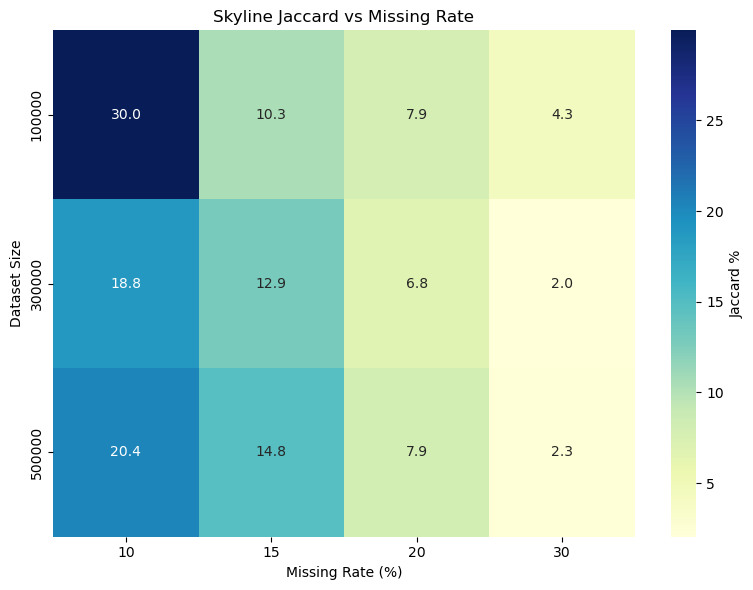

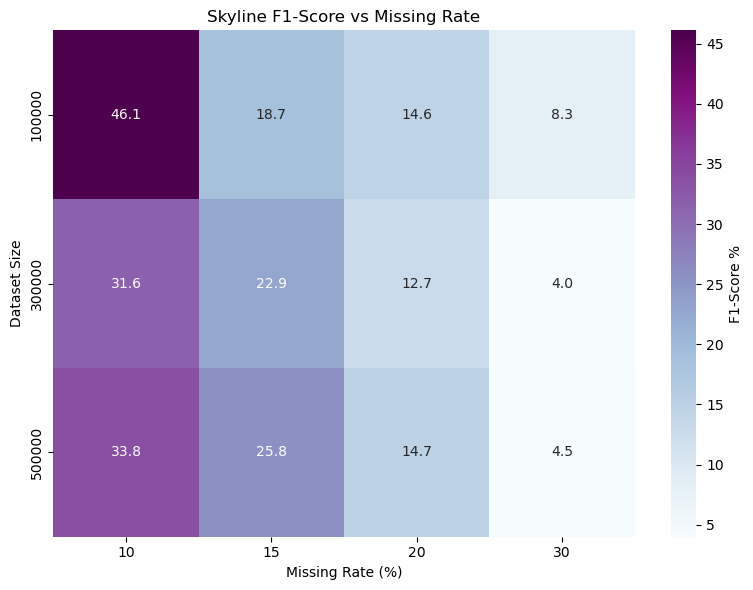

✅ Hoàn tất: đã tính Jaccard + F1-Score và lưu heatmap.


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
import os
import glob
from typing import Set

# đảm bảo SparkSession
spark = SparkSession.builder.getOrCreate()

sizes = [100000, 300000, 500000]
missing_rates = [0.1, 0.15, 0.2, 0.3]
criteria_7d = ["ARRIVAL_DELAY", "TAXI_TOTAL", "ELAPSED_TIME",
               "DEPARTURE_DELAY", "DISTANCE", "TAXI_OUT", "TAXI_IN"]

# thư mục
orig_skyline_dir = "/home/jovyan/output/xgboost/skyline_bbs_results"
imputed_skyline_dir = "/home/jovyan/output/xgboost/data_missing/data_imputed/skyline_bbs_imputed"
output_dir = "/home/jovyan/output/xgboost/analysis_results"
os.makedirs(output_dir, exist_ok=True)

# Xóa file CSV và heatmap cũ nếu tồn tại
acc_csv = os.path.join(output_dir, "skyline_jaccard_f1.csv")
if os.path.exists(acc_csv):
    os.remove(acc_csv)
for img in ["skyline_jaccard_heatmap.png", "skyline_f1_heatmap.png"]:
    img_path = os.path.join(output_dir, img)
    if os.path.exists(img_path):
        os.remove(img_path)

def sparkdf_to_pointset(sdf):
    """Spark DF hoặc Pandas DF -> set of tuples"""
    if sdf is None:
        return set()
    try:
        pdf = sdf.select(criteria_7d).toPandas()
    except Exception:
        pdf = sdf[criteria_7d].copy() if isinstance(sdf, pd.DataFrame) else None
    if pdf is None:
        return set()
    pdf = pdf.fillna(value=pd.NA)
    return set(map(lambda row: tuple(row.tolist()), pdf.to_numpy()))

def find_parquet_file(dir_path, pattern_prefix):
    """Tìm file parquet theo pattern"""
    if not os.path.exists(dir_path):
        return None
    candidates = glob.glob(os.path.join(dir_path, f"*{pattern_prefix}*.parquet"))
    return candidates[0] if candidates else None

results = []

for size in sizes:
    # Load original skyline
    orig_pattern = f"skyline_bbs_{size//1000}k"
    orig_file = find_parquet_file(orig_skyline_dir, orig_pattern)
    if orig_file is None:
        continue
    try:
        orig_spark_df = spark.read.parquet(orig_file)
        sky_orig_set = sparkdf_to_pointset(orig_spark_df)
    except Exception:
        continue

    for miss_rate in missing_rates:
        miss_int = int(miss_rate * 100)
        imp_pattern = f"skyline_bbs_{size//1000}k_miss{miss_int}"
        imp_file = find_parquet_file(imputed_skyline_dir, imp_pattern)
        if imp_file is None:
            continue
        try:
            imp_spark_df = spark.read.parquet(imp_file)
            sky_imp_set = sparkdf_to_pointset(imp_spark_df)

            # --- Tính các chỉ số ---
            inter = sky_orig_set.intersection(sky_imp_set)
            union_len = len(sky_orig_set.union(sky_imp_set))

            # Jaccard
            jaccard = (len(inter) / union_len * 100) if union_len > 0 else 0.0

            # Precision, Recall (dựa trên Skyline gốc và nội suy)
            precision = (len(inter) / len(sky_imp_set) * 100) if len(sky_imp_set) > 0 else 0.0
            recall = (len(inter) / len(sky_orig_set) * 100) if len(sky_orig_set) > 0 else 0.0

            # F1-Score
            f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0

            results.append((size, miss_int, len(sky_orig_set),
                            len(sky_imp_set), len(inter),
                            jaccard, f1))
        except Exception:
            continue

# DataFrame kết quả
df_acc = pd.DataFrame(results, columns=["Size", "MissingRate", "OrigSkyline",
                                        "ImpSkyline", "Intersection",
                                        "Jaccard", "F1"])

# Pivot cho heatmap
pivot_jac = df_acc.pivot(index="Size", columns="MissingRate", values="Jaccard").sort_index() if not df_acc.empty else pd.DataFrame()
pivot_f1 = df_acc.pivot(index="Size", columns="MissingRate", values="F1").sort_index() if not df_acc.empty else pd.DataFrame()

# Lưu CSV
if not df_acc.empty:
    acc_csv = os.path.join(output_dir, "skyline_jaccard_f1.csv")
    df_acc.to_csv(acc_csv, index=False)
    print(f"💾 Đã lưu kết quả Jaccard + F1 vào: {acc_csv}")
else:
    print("⚠️ Không có dữ liệu để lưu (df_acc rỗng).")

# In kết quả
if not df_acc.empty:
    print("\n💡 Skyline Jaccard (%)")
    print(pivot_jac)
    print("\n🏁 Skyline F1-Score (%)")
    print(pivot_f1)
else:
    print("⚠️ Không có dữ liệu để hiển thị.")

# Vẽ heatmap Jaccard
if not pivot_jac.empty:
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_jac, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Jaccard %'})
    plt.title("Skyline Jaccard vs Missing Rate")
    plt.ylabel("Dataset Size")
    plt.xlabel("Missing Rate (%)")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "skyline_jaccard_heatmap.png"))
    plt.show()

# Vẽ heatmap F1
if not pivot_f1.empty:
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_f1, annot=True, fmt=".1f", cmap="BuPu", cbar_kws={'label': 'F1-Score %'})
    plt.title("Skyline F1-Score vs Missing Rate")
    plt.ylabel("Dataset Size")
    plt.xlabel("Missing Rate (%)")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "skyline_f1_heatmap.png"))
    plt.show()

print("✅ Hoàn tất: đã tính Jaccard + F1-Score và lưu heatmap.")

# **Possible Skyline trên dữ liệu missing**

In [19]:
# === Cell POSSIBLE SKYLINE (sửa logic giống code mẫu) ===
from pyspark.sql import SparkSession, functions as F
from pyspark.storagelevel import StorageLevel
import pandas as pd
import os, glob, time, shutil, csv

# ==== Khởi tạo Spark ====
spark = SparkSession.builder.appName("PossibleSkylineMissing").getOrCreate()

# ==== Tham số chung ====
KEY_COL = "ID"  # giữ tên cột ID như dữ liệu gốc
criteria_7d = ["ARRIVAL_DELAY", "TAXI_TOTAL", "ELAPSED_TIME",
               "DEPARTURE_DELAY", "DISTANCE", "TAXI_OUT", "TAXI_IN"]
sizes = [100000, 300000, 500000]
missing_rates = [0.1, 0.15, 0.2, 0.3]

# ==== Đường dẫn ====
orig_skyline_dir = "/home/jovyan/output/xgboost/skyline_bbs_results"
missing_data_dir = "/home/jovyan/output/xgboost/data_missing"
out_possible_dir = os.path.join(missing_data_dir, "skyline_possible_results")
os.makedirs(out_possible_dir, exist_ok=True)
csv_path = os.path.join(out_possible_dir, "possible_skyline_results.csv")

# 🧹 === XÓA FILE CŨ TRƯỚC KHI CHẠY ===
if os.path.exists(out_possible_dir):
    for file in glob.glob(os.path.join(out_possible_dir, "*")):
        try:
            if os.path.isfile(file):
                os.remove(file)
            elif os.path.isdir(file):
                shutil.rmtree(file)
        except Exception as e:
            print(f"⚠️ Không thể xóa {file}: {e}")
print(f"🧩 Thư mục {out_possible_dir} đã được làm sạch trước khi chạy mới.\n")

# ==== Hàm chi phối "Possible" ====
def dominates_possible(r1, r2, criteria):
    """
    Kiểm tra xem r1 có thể chi phối r2 không (POSSIBLE SKYLINE)
    - Nếu r1 tốt hơn hoặc bằng r2 ở mọi chiều mà không bị mâu thuẫn dữ liệu (None)
    - Và có ít nhất một chiều tốt hơn (nhỏ hơn)
    """
    better = False
    for c in criteria:
        v1, v2 = r1[c], r2[c]
        # Nếu một trong hai giá trị thiếu => không kết luận được, bỏ qua chiều này
        if v1 is None or v2 is None:
            continue
        if v1 > v2:  # xấu hơn
            return False
        if v1 < v2:
            better = True
    return better


# ==== Hàm tính Possible Skyline (BBS giản lược) ====
def possible_skyline(df, criteria, num_partitions=200):
    start = time.time()
    rdd = df.select(["ID"] + criteria).rdd.repartition(num_partitions)

    def partition_sky(it):
        local = []
        for row in it:
            rowd = row.asDict()
            dominated = False
            to_remove = []
            for s in local:
                sd = s.asDict()
                if dominates_possible(sd, rowd, criteria):
                    dominated = True
                    break
                if dominates_possible(rowd, sd, criteria):
                    to_remove.append(s)
            if not dominated:
                for r in to_remove:
                    local.remove(r)
                local.append(row)
        return local

    partial = rdd.mapPartitions(partition_sky).collect()
    final = []
    for row in partial:
        rowd = row.asDict()
        dominated = False
        to_remove = []
        for s in final:
            sd = s.asDict()
            if dominates_possible(sd, rowd, criteria):
                dominated = True
                break
            if dominates_possible(rowd, sd, criteria):
                to_remove.append(s)
        if not dominated:
            for r in to_remove:
                final.remove(r)
            final.append(row)

    skyline_ids = [r["ID"] for r in final]
    elapsed = time.time() - start
    print(f"✅ POSSIBLE Skyline xong ({len(skyline_ids)} điểm), thời gian {elapsed:.2f}s")
    sky_df = spark.createDataFrame([(i,) for i in skyline_ids], ["ID"]).join(df, "ID")
    return sky_df, elapsed


# ==== Hàm tìm file parquet ====
def find_parquet(dir_path, pattern):
    files = glob.glob(os.path.join(dir_path, f"*{pattern}*.parquet"))
    return files[0] if files else None


# ==== Thực thi POSSIBLE SKYLINE + tính Jaccard & F1 ====
results_possible = []
for size in sizes:
    orig_file = find_parquet(orig_skyline_dir, f"skyline_bbs_{size//1000}k")
    if not orig_file:
        continue
    orig_df = spark.read.parquet(orig_file)
    orig_set = set(tuple(x) for x in orig_df.select(criteria_7d).toPandas().to_numpy())

    for miss in missing_rates:
        miss_int = int(miss * 100)
        miss_file = find_parquet(missing_data_dir, f"data_{size//1000}k_miss{miss_int}")
        if not miss_file:
            continue
        print(f"\n🚀 POSSIBLE Skyline cho {size:,} dòng, tỷ lệ thiếu {miss_int}% ...")
        df_missing = spark.read.parquet(miss_file)

        # Ép kiểu numeric
        for c in criteria_7d:
            df_missing = df_missing.withColumn(c, F.col(c).cast("double"))

        sky_df, t = possible_skyline(df_missing, criteria_7d)
        out_path = os.path.join(out_possible_dir, f"possible_skyline_{size//1000}k_miss{miss_int}.parquet")
        sky_df.write.mode("overwrite").parquet(out_path)

        # --- So sánh với Skyline đầy đủ ---
        poss_set = set(tuple(x) for x in sky_df.select(criteria_7d).toPandas().to_numpy())
        inter = orig_set.intersection(poss_set)
        union_len = len(orig_set.union(poss_set))
        jaccard = (len(inter) / union_len * 100) if union_len else 0
        precision = (len(inter) / len(poss_set) * 100) if len(poss_set) else 0
        recall = (len(inter) / len(orig_set) * 100) if len(orig_set) else 0
        f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) else 0

        results_possible.append((size, miss_int, len(orig_set), len(poss_set), len(inter),
                                 jaccard, f1, t))
        print(f"📊 Jaccard={jaccard:.2f}% | F1={f1:.2f}% | |Sky|={len(poss_set)}")

# ==== Lưu kết quả tổng hợp ====
df_res = pd.DataFrame(results_possible,
                      columns=["Kích thước", "Tỷ lệ thiếu (%)", "Skyline đầy đủ", 
                               "Skyline POSSIBLE", "Giao nhau", 
                               "Jaccard (%)", "F1 (%)", "Thời gian (s)"])
csv_path = os.path.join(out_possible_dir, "possible_skyline_results.csv")
df_res.to_csv(csv_path, index=False)

print(f"\n💾 Đã lưu kết quả tổng hợp vào: {csv_path}")
df_res


🧩 Thư mục /home/jovyan/output/xgboost/data_missing/skyline_possible_results đã được làm sạch trước khi chạy mới.


🚀 POSSIBLE Skyline cho 100,000 dòng, tỷ lệ thiếu 10% ...
✅ POSSIBLE Skyline xong (67 điểm), thời gian 2.55s
📊 Jaccard=21.05% | F1=34.78% | |Sky|=67

🚀 POSSIBLE Skyline cho 100,000 dòng, tỷ lệ thiếu 15% ...
✅ POSSIBLE Skyline xong (27 điểm), thời gian 2.57s
📊 Jaccard=4.93% | F1=9.39% | |Sky|=27

🚀 POSSIBLE Skyline cho 100,000 dòng, tỷ lệ thiếu 20% ...
✅ POSSIBLE Skyline xong (41 điểm), thời gian 2.57s
📊 Jaccard=6.57% | F1=12.33% | |Sky|=41

🚀 POSSIBLE Skyline cho 100,000 dòng, tỷ lệ thiếu 30% ...
✅ POSSIBLE Skyline xong (45 điểm), thời gian 2.48s
📊 Jaccard=0.87% | F1=1.73% | |Sky|=45

🚀 POSSIBLE Skyline cho 300,000 dòng, tỷ lệ thiếu 10% ...
✅ POSSIBLE Skyline xong (97 điểm), thời gian 3.89s
📊 Jaccard=20.00% | F1=33.33% | |Sky|=97

🚀 POSSIBLE Skyline cho 300,000 dòng, tỷ lệ thiếu 15% ...
✅ POSSIBLE Skyline xong (58 điểm), thời gian 4.62s
📊 Jaccard=11.06% | F1=19.91% | |Sky|=

,Kích thước,Tỷ lệ thiếu (%),Skyline đầy đủ,Skyline POSSIBLE,Giao nhau,Jaccard (%),F1 (%),Thời gian (s)
0,100000,10,186,67,44,21.052632,34.782609,2.554149
1,100000,15,186,27,10,4.926108,9.389671,2.570994
2,100000,20,186,41,14,6.572770,12.334802,2.571185
3,100000,30,186,45,2,0.873362,1.731602,2.483821
4,300000,10,173,97,45,20.000000,33.333333,3.894171
5,300000,15,173,58,23,11.057692,19.913420,4.617151
6,300000,20,173,27,8,4.166667,8.000000,3.556123
7,300000,30,173,90,1,0.381679,0.760456,3.367140
8,500000,10,183,68,35,16.203704,27.888446,4.429267
9,500000,15,183,39,19,9.359606,17.117117,4.151000


# **Xây dựng mô hình đánh giá**

✅ Saved chart → /home/jovyan/output/xgboost/logs/chart_bounded/overlay_f1_comparison.png


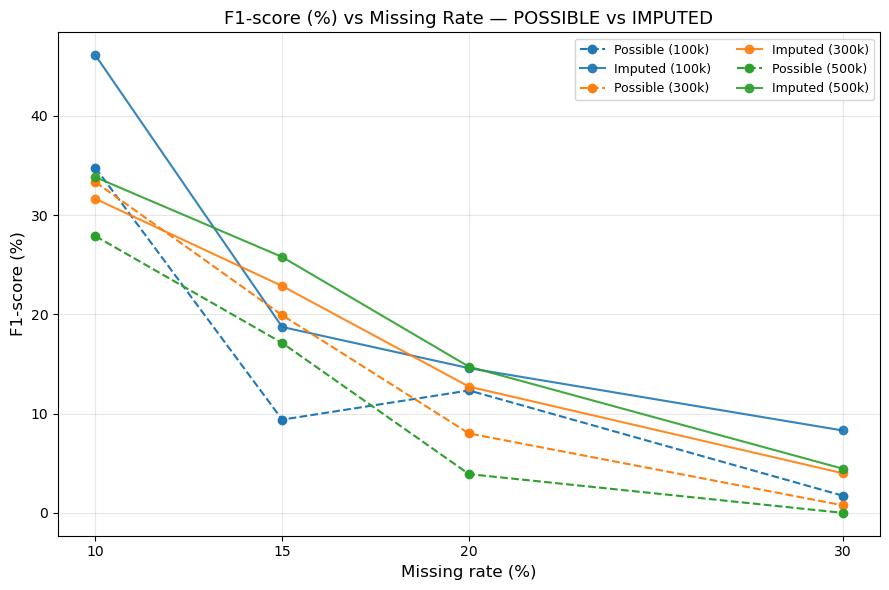

✅ Saved chart → /home/jovyan/output/xgboost/logs/chart_bounded/overlay_jaccard_comparison.png


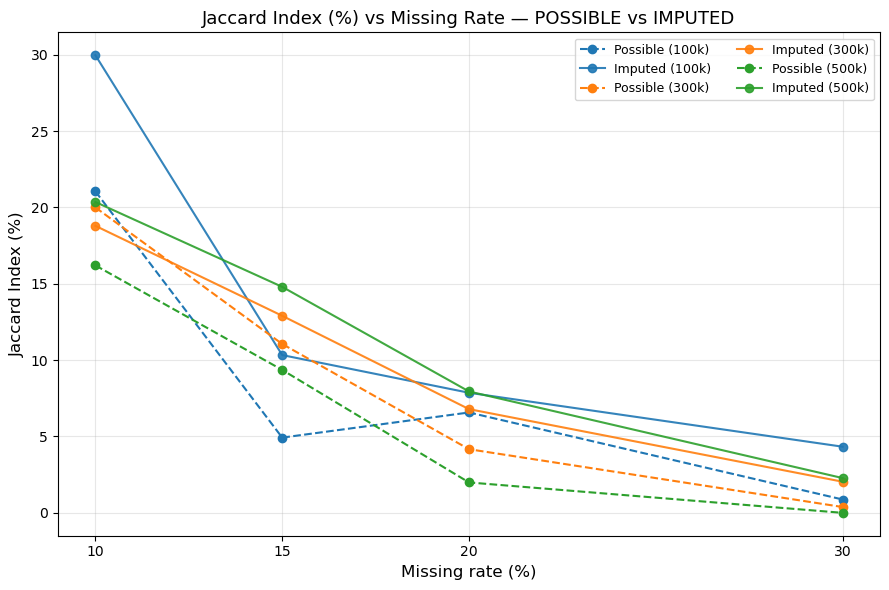


🎯 Cell 8 hoàn tất — Đã lưu biểu đồ so sánh F1 & Jaccard trong thư mục:
/home/jovyan/output/xgboost/logs/chart_bounded


In [20]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# ======== Đường dẫn ========
BASE_DIR = "/home/jovyan/output/xgboost"
CSV_POSSIBLE = os.path.join(BASE_DIR, "data_missing/skyline_possible_results/possible_skyline_results.csv")
CSV_IMPUTED = os.path.join(BASE_DIR, "analysis_results/skyline_jaccard_f1.csv")
OUT_DIR = os.path.join(BASE_DIR, "logs/chart_bounded")
os.makedirs(OUT_DIR, exist_ok=True)

# ======== Hàm đọc CSV & chuẩn hóa ========
def load_csv(path):
    df = pd.read_csv(path)
    df.columns = [c.strip().lower() for c in df.columns]
    
    rename_map = {
        "tỷ lệ thiếu (%)": "miss_rate_pct",
        "missingrate": "miss_rate_pct",
        "missingrate(%)": "miss_rate_pct",
        "missing_rate": "miss_rate_pct",
        "missing_rate(%)": "miss_rate_pct",
        "missingratepct": "miss_rate_pct",
        "missingrate_pct": "miss_rate_pct",
        "missingratepercent": "miss_rate_pct",
        "size": "size",
        "kích thước": "size",
        "f1 (%)": "f1_percent",
        "f1": "f1_percent",
        "f1 (%) ": "f1_percent",
        "jaccard (%)": "jaccard_percent",
        "jaccard": "jaccard_percent"
    }
    df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})
    
    for c in ["miss_rate_pct", "f1_percent", "jaccard_percent"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    if "size" in df.columns:
        df["size"] = df["size"].astype(str)
        df["size"] = df["size"].replace({
            "100000": "100k",
            "300000": "300k",
            "500000": "500k"
        })
    return df

df_pos = load_csv(CSV_POSSIBLE)
df_imp = load_csv(CSV_IMPUTED)

# ======== Cấu hình chung ========
sizes = ["100k", "300k", "500k"]
rate_order = [10, 15, 20, 30]
palette = {
    "100k": "#1f77b4",  # blue
    "300k": "#ff7f0e",  # orange
    "500k": "#2ca02c",  # green
}

# ======== Hàm vẽ Overlay Chart ========
def overlay_plot(metric_col, ylabel, filename):
    plt.figure(figsize=(9,6))

    for sz in sizes:
        # Dữ liệu POSSIBLE
        p = df_pos[(df_pos["size"] == sz) & (df_pos["miss_rate_pct"].isin(rate_order))][["miss_rate_pct", metric_col]]

        # Dữ liệu IMPUTED
        rate_col = None
        for cand in ["miss_rate_pct", "missingrate", "missingrate(%)", "missing_rate", "missing_rate(%)", "missingratepct", "missingrate_pct", "missingratepercent"]:
            if cand in df_imp.columns:
                rate_col = cand
                break
        if rate_col is None:
            raise ValueError("❌ Không tìm thấy cột tỷ lệ thiếu trong CSV imputed!")

        i = df_imp[(df_imp["size"] == sz) & (df_imp[rate_col].isin(rate_order))][[rate_col, metric_col]]
        i = i.rename(columns={rate_col: "miss_rate_pct"})

        # Merge 2 tập
        mg = pd.merge(
            p.rename(columns={metric_col: "possible"}),
            i.rename(columns={metric_col: "imputed"}),
            on="miss_rate_pct",
            how="inner"
        ).sort_values("miss_rate_pct")

        if mg.empty:
            print(f"⚠️ Không có dữ liệu trùng cho {sz} ({metric_col})")
            continue

        x = mg["miss_rate_pct"].values
        y_possible = mg["possible"].values
        y_imputed = mg["imputed"].values
        c = palette[sz]

        plt.plot(x, y_possible, "o--", color=c, label=f"Possible ({sz})")
        plt.plot(x, y_imputed, "o-",  color=c, alpha=0.9, label=f"Imputed ({sz})")

    plt.xlabel("Missing rate (%)", fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(f"{ylabel} vs Missing Rate — POSSIBLE vs IMPUTED", fontsize=13)
    plt.xticks(rate_order)
    plt.grid(alpha=0.3)
    plt.legend(ncol=2, fontsize=9, loc="best")
    plt.tight_layout()

    out_path = os.path.join(OUT_DIR, filename)
    plt.savefig(out_path, dpi=200)
    print(f"✅ Saved chart → {out_path}")
    plt.show()

# ======== Sinh biểu đồ ========
overlay_plot("f1_percent", "F1-score (%)", "overlay_f1_comparison.png")
overlay_plot("jaccard_percent", "Jaccard Index (%)", "overlay_jaccard_comparison.png")

print("\n🎯 Cell 8 hoàn tất — Đã lưu biểu đồ so sánh F1 & Jaccard trong thư mục:")
print(OUT_DIR)

In [22]:
# ==============================================================
# 🧩 Cell 9 — Tổng hợp kết quả POSSIBLE Skyline + Lưu CSV + Ảnh
# ==============================================================

import os, shutil
import pandas as pd

# ==== Đường dẫn ====
BASE_DIR = "/home/jovyan/output/xgboost"
CSV_POSSIBLE = os.path.join(BASE_DIR, "data_missing/skyline_possible_results/possible_skyline_results.csv")
OUT_DIR = os.path.join(BASE_DIR, "analysis_results/final_report")
CHART_SRC_DIR = os.path.join(BASE_DIR, "logs/chart_bounded")
os.makedirs(OUT_DIR, exist_ok=True)

# ==== Đọc kết quả POSSIBLE ====
df_pos = pd.read_csv(CSV_POSSIBLE)

# ==== Chuẩn hóa tên cột ====
rename_map = {
    "Kích thước": "size",
    "Tỷ lệ thiếu (%)": "miss_rate_pct",
    "Skyline đầy đủ": "n_true",
    "Skyline POSSIBLE": "n_possible",
    "Giao nhau": "n_intersection",
    "Jaccard (%)": "jaccard_percent",
    "F1 (%)": "f1_percent",
    "Thời gian (s)": "time_seconds"
}
df_pos = df_pos.rename(columns={k: v for k, v in rename_map.items() if k in df_pos.columns})

# ==== Thêm các cột còn thiếu ====
df_pos["n_union"] = df_pos["n_true"] + df_pos["n_possible"] - df_pos["n_intersection"]
df_pos["precision_percent"] = df_pos.apply(
    lambda r: (r["n_intersection"] / r["n_possible"] * 100) if r["n_possible"] else 0, axis=1
)
df_pos["recall_percent"] = df_pos.apply(
    lambda r: (r["n_intersection"] / r["n_true"] * 100) if r["n_true"] else 0, axis=1
)

# ==== Thêm đường dẫn output parquet tương ứng ====
def make_parquet_path(row):
    base = "/home/jovyan/output/original/skyline_results_possible"
    return os.path.join(base, f"data_{int(row['size'])//1000}k_miss{int(row['miss_rate_pct'])}_skyline.parquet")

df_pos["output_parquet"] = df_pos.apply(make_parquet_path, axis=1)

# ==== Chọn & sắp xếp cột theo mẫu ====
cols = [
    "size", "miss_rate_pct", "n_true", "n_possible", "n_intersection",
    "n_union", "precision_percent", "recall_percent",
    "f1_percent", "jaccard_percent", "time_seconds", "output_parquet"
]
df_final = df_pos[cols].sort_values(["size", "miss_rate_pct"]).reset_index(drop=True)

# ==== Lưu CSV kết quả ====
final_csv = os.path.join(OUT_DIR, "skyline_possible_final_results.csv")
df_final.to_csv(final_csv, index=False)
print(f"💾 Đã lưu kết quả hợp nhất tại: {final_csv}")

# ==== Sao chép 2 ảnh biểu đồ từ cell 8 ====
for img_name in ["overlay_f1_comparison.png", "overlay_jaccard_comparison.png"]:
    src = os.path.join(CHART_SRC_DIR, img_name)
    dst = os.path.join(OUT_DIR, img_name)
    if os.path.exists(src):
        shutil.copy(src, dst)
        print(f"🖼️ Đã sao chép: {img_name}")
    else:
        print(f"⚠️ Không tìm thấy ảnh {img_name} trong {CHART_SRC_DIR}")

print("\n✅ Cell 9 hoàn tất — CSV và 2 ảnh đã lưu trong:")
print(OUT_DIR)
df_final.head(12)


💾 Đã lưu kết quả hợp nhất tại: /home/jovyan/output/xgboost/analysis_results/final_report/skyline_possible_final_results.csv
🖼️ Đã sao chép: overlay_f1_comparison.png
🖼️ Đã sao chép: overlay_jaccard_comparison.png

✅ Cell 9 hoàn tất — CSV và 2 ảnh đã lưu trong:
/home/jovyan/output/xgboost/analysis_results/final_report


,size,miss_rate_pct,n_true,n_possible,n_intersection,n_union,precision_percent,recall_percent,f1_percent,jaccard_percent,time_seconds,output_parquet
0,100000,10,186,67,44,209,65.671642,23.655914,34.782609,21.052632,2.554149,/home/jovyan/output/original/skyline_results_p...
1,100000,15,186,27,10,203,37.037037,5.376344,9.389671,4.926108,2.570994,/home/jovyan/output/original/skyline_results_p...
2,100000,20,186,41,14,213,34.146341,7.526882,12.334802,6.572770,2.571185,/home/jovyan/output/original/skyline_results_p...
3,100000,30,186,45,2,229,4.444444,1.075269,1.731602,0.873362,2.483821,/home/jovyan/output/original/skyline_results_p...
4,300000,10,173,97,45,225,46.391753,26.011561,33.333333,20.000000,3.894171,/home/jovyan/output/original/skyline_results_p...
5,300000,15,173,58,23,208,39.655172,13.294798,19.913420,11.057692,4.617151,/home/jovyan/output/original/skyline_results_p...
6,300000,20,173,27,8,192,29.629630,4.624277,8.000000,4.166667,3.556123,/home/jovyan/output/original/skyline_results_p...
7,300000,30,173,90,1,262,1.111111,0.578035,0.760456,0.381679,3.367140,/home/jovyan/output/original/skyline_results_p...
8,500000,10,183,68,35,216,51.470588,19.125683,27.888446,16.203704,4.429267,/home/jovyan/output/original/skyline_results_p...
9,500000,15,183,39,19,203,48.717949,10.382514,17.117117,9.359606,4.151000,/home/jovyan/output/original/skyline_results_p...
